# Machine Learning with Phyton

Megan Graciela Nauli - 950251


A simple yet powerful marketing technique is an analysis utilizing _recency_ (how recent was the customer's last purchase), _frequency_ (how often did the customer make a purchase in a given period) and _monetary_ (how much money did the customer spend in a given period) data to identify the best customers and perform targeted marketing campaigns. 

As data scientist you are asked to segment the customers using transaction data and profile them based-on their characteristics (recency, frequency, monetary). After you find the segments, name them using understandable words so marketing team can easily create campaign strategies.

**Data:**
`../data/transactions.csv`

**Hints:** 
For each customer id, generate time difference between their last transaction and today. You should also calculate number of transaction and total amount of spending. You are allowed to use SQL.

**Output:**
Push the *executed* notebook into your github repo and submit the URL to ketua kelas no later than August 21, 2021. Note that notebook must contain explanatory analysis and clustering as well as story about your findings.

**Goodluck!**

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import time
import datetime

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
import os
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

### Data Exploration

In [2]:
df = pd.read_csv(r'../data/transactions.csv')
df.head()

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


In [3]:
df.shape

(125000, 3)

In [4]:
df.describe()

,trans_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


In [5]:
#check missing value
data_missing_value = df.isnull().sum().reset_index()
data_missing_value

,index,0
0,customer_id,0
1,trans_date,0
2,trans_amount,0


Result : No missing data

In [6]:
df.duplicated().sum()

6

Result : 6 Duplicate Data

In [7]:
df=df.drop_duplicates()
df.duplicated().sum()

0

Result : No more Duplicate Data

### Recency
how recent was the customer's last purchase

In [8]:
df['trans_date'] = pd.to_datetime(df.trans_date, errors='coerce')

In [9]:
today = datetime.datetime(2021,8,26)
recency=df.groupby('customer_id').agg({'trans_date': 'max'}).reset_index()
recency.columns=['customer_id','last_trans']
recency['recency']=today-recency['last_trans']
recency=recency.drop(['last_trans'],axis=1)
recency['recency'] = pd.DataFrame(recency['recency'].astype('timedelta64[D]'))
recency

,customer_id,recency
0,CS1112,590.0
1,CS1113,564.0
2,CS1114,561.0
3,CS1115,539.0
4,CS1116,732.0
...,...,...
6884,CS8996,626.0
6885,CS8997,790.0
6886,CS8998,613.0
6887,CS8999,786.0


### Frequency
how often did the customer make a purchase in a given period

In [10]:
frequency=df.groupby('customer_id').agg({'trans_amount':'count'}).reset_index()
frequency.columns=['customer_id','frequency']
frequency

,customer_id,frequency
0,CS1112,15
1,CS1113,20
2,CS1114,19
3,CS1115,22
4,CS1116,13
...,...,...
6884,CS8996,13
6885,CS8997,14
6886,CS8998,13
6887,CS8999,12


### Monetary
how much money did the customer spend in a given period

In [11]:
monetary=df.groupby('customer_id').agg({'trans_amount': 'sum'}).reset_index()
monetary.columns=['customer_id','monetary']
monetary

,customer_id,monetary
0,CS1112,1012
1,CS1113,1490
2,CS1114,1432
3,CS1115,1659
4,CS1116,857
...,...,...
6884,CS8996,582
6885,CS8997,543
6886,CS8998,624
6887,CS8999,383


### RFM

In [12]:
RFM = RFM=recency.merge(frequency, on='customer_id')
RFM=RFM.merge(monetary, on='customer_id')
RFM

,customer_id,recency,frequency,monetary
0,CS1112,590.0,15,1012
1,CS1113,564.0,20,1490
2,CS1114,561.0,19,1432
3,CS1115,539.0,22,1659
4,CS1116,732.0,13,857
...,...,...,...,...
6884,CS8996,626.0,13,582
6885,CS8997,790.0,14,543
6886,CS8998,613.0,13,624
6887,CS8999,786.0,12,383


In [13]:
RFM

,customer_id,recency,frequency,monetary
0,CS1112,590.0,15,1012
1,CS1113,564.0,20,1490
2,CS1114,561.0,19,1432
3,CS1115,539.0,22,1659
4,CS1116,732.0,13,857
...,...,...,...,...
6884,CS8996,626.0,13,582
6885,CS8997,790.0,14,543
6886,CS8998,613.0,13,624
6887,CS8999,786.0,12,383


### Data Visualization

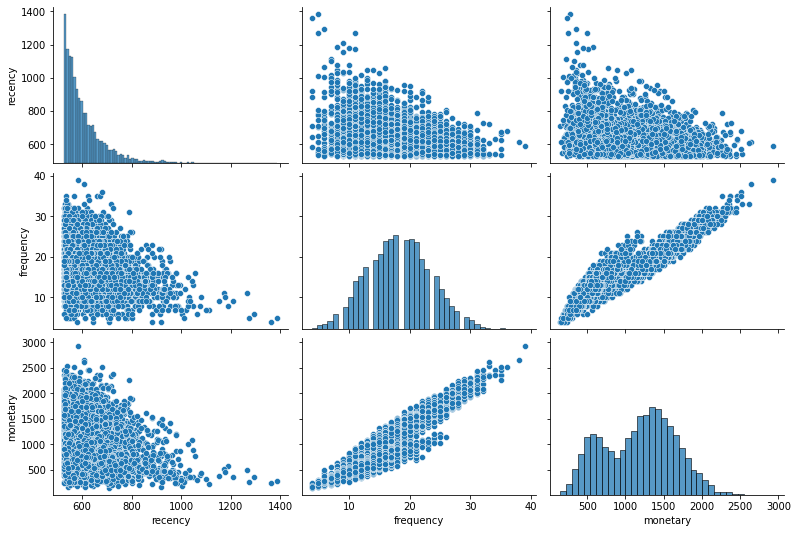

In [14]:
sns.pairplot(RFM.drop('customer_id', axis=1), aspect=1.5)
plt.show()

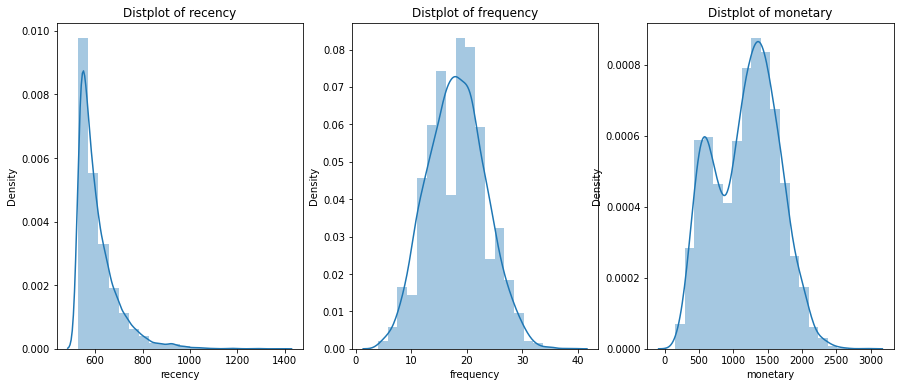

In [15]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['recency' , 'frequency' , 'monetary']:
    n += 1
    plt.subplot(1 , 3 , n)
    sns.distplot(RFM[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))
plt.show()

### Standardization

In [16]:
X=RFM[['recency','frequency','monetary']]

from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X)
RFM_std = pd.DataFrame(data = X_std, columns = ['recency','frequency','monetary'])
RFM_std.describe()

,recency,frequency,monetary
count,6.889000e+03,6.889000e+03,6.889000e+03
mean,-3.135506e-16,-2.310373e-16,-1.320213e-16
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-9.510168e-01,-2.723785e+00,-2.211731e+00
25%,-6.821344e-01,-7.980317e-01,-8.549248e-01
50%,-3.197276e-01,-2.773040e-02,1.025680e-01
75%,3.583238e-01,7.425709e-01,7.315936e-01
max,9.079468e+00,4.016351e+00,3.765085e+00


### Clustering
Use the data to develop a model using K Means algorithm

In [17]:
def k_means_inertia_silhouette(X, k_max = 10, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(X)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()
    
    return inertia, silhouette

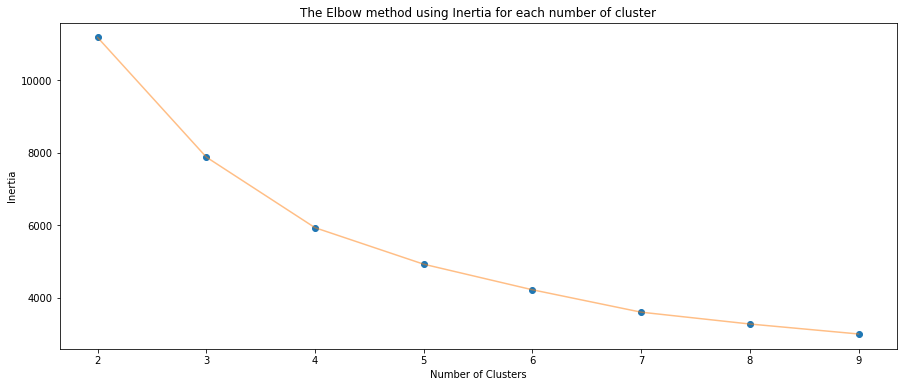

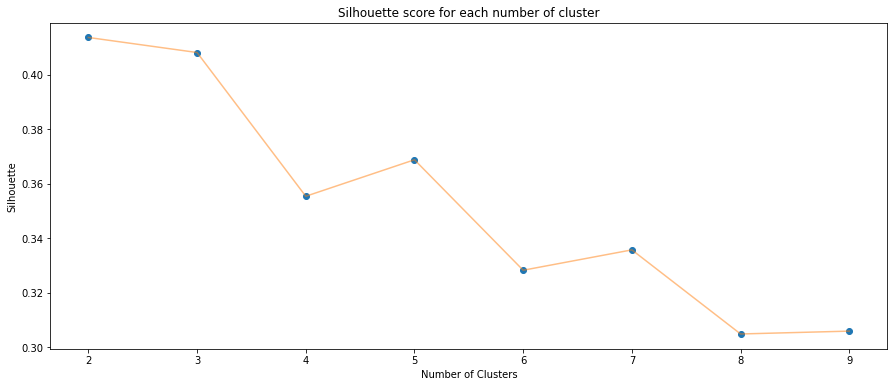

In [18]:
inertia, silhouette = k_means_inertia_silhouette(RFM_std.values)

We choose the k for which inertia becomes first starts to diminish. In the plot, this is visible as an elbow. If Silhouette score is used, choose the k with the highest score. From the plot, we can say that the Inertia rate of change start to slowing down at k = 5. The silhouette also highest at that point.  

In [19]:
k_means = KMeans(init = "k-means++", n_clusters = 5, n_init = 12)

In [20]:
k_means.fit(RFM_std.values)

KMeans(n_clusters=5, n_init=12)

In [21]:
segment = k_means.labels_
segment

array([3, 3, 3, ..., 1, 2, 1])

In [22]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[ 0.96859555,  0.11649177,  0.20538322],
       [-0.16146695, -1.05410067, -1.16460015],
       [ 2.65132848, -1.24364205, -1.23277952],
       [-0.49837057,  0.0939324 ,  0.18005903],
       [-0.40798854,  1.32252319,  1.26735205]])

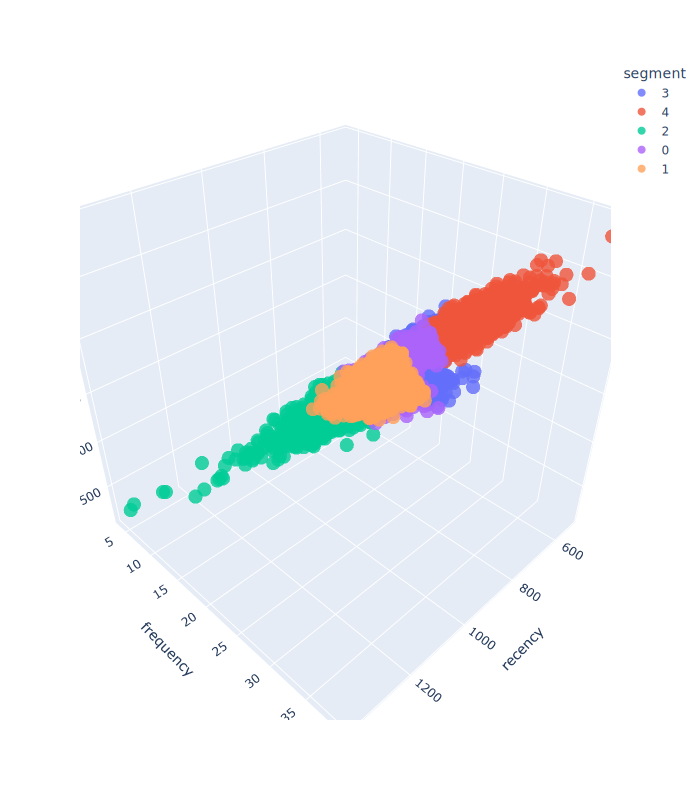

In [23]:
RFM['segment'] = list(map(str, segment))
fig = px.scatter_3d(RFM, x='recency', y='frequency', z='monetary', color='segment',
                   opacity = 0.8, height=800)
fig.show('svg') # to show as static image: fig.show('svg') 

In [24]:
RFM

,customer_id,recency,frequency,monetary,segment
0,CS1112,590.0,15,1012,3
1,CS1113,564.0,20,1490,3
2,CS1114,561.0,19,1432,3
3,CS1115,539.0,22,1659,4
4,CS1116,732.0,13,857,2
...,...,...,...,...,...
6884,CS8996,626.0,13,582,1
6885,CS8997,790.0,14,543,2
6886,CS8998,613.0,13,624,1
6887,CS8999,786.0,12,383,2


In [25]:
RFM_segment = RFM.drop('customer_id', axis=1).groupby('segment').agg({'recency' : ['count','min','max','mean'], 'frequency' : ['count','min','max','mean'], 'monetary':['count','min','max','mean']}).reset_index()
RFM_segment

segment recency                            frequency                     \
            count    min     max        mean     count min max       mean   
0       0     920  629.0   918.0  692.388043       920  13  27  18.733696   
1       1    1743  528.0   715.0  595.610442      1743   4  18  12.662651   
2       2     428  710.0  1386.0  836.689252       428   4  22  11.689252   
3       3    2240  528.0   630.0  566.756250      2240  14  25  18.625446   
4       4    1558  528.0   788.0  574.469833      1558  21  39  25.008986   

  monetary                           
     count   min   max         mean  
0      920   656  1905  1274.039130  
1     1743   157  1092   635.644291  
2      428   149  1498   604.932243  
3     2240   670  1712  1262.470536  
4     1558  1348  2933  1769.437741

### Segmentation:

Segment 3.**Loyal Customer** : 2nd lowest recency (2nd most recent), highest frequency, highest monetary

Segment 2. **Potentially Loyal customers** : Lowest recency (most recent), middle frequency, middle monetary 


Segment 1. **At risk customers, used to be loyal customers but have no activity recently. Need to be reconnected.** : 2nd highest recency (2nd least recent), 2nd highest frequency, 2nd highest monetary 

Segment 0. **About to sleep customers** : Middle recency, 2nd lowest frequency, 2nd lowest monetary 

Segment 4. **Hibernating customer** : Highest recency (least recent), lowest frequency, lowest monetary 